torch.Size([1929, 210, 381])
torch.Size([1929, 210, 381])


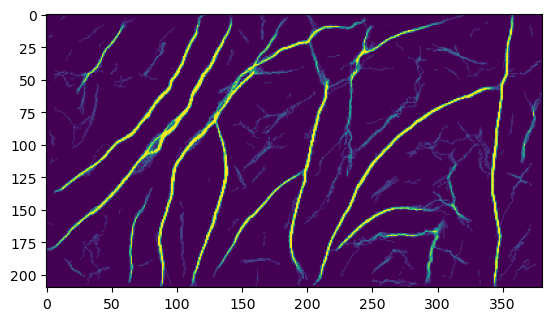

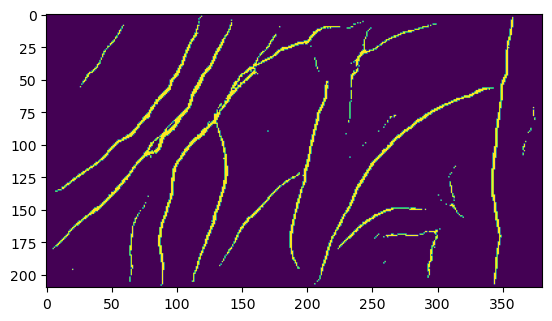

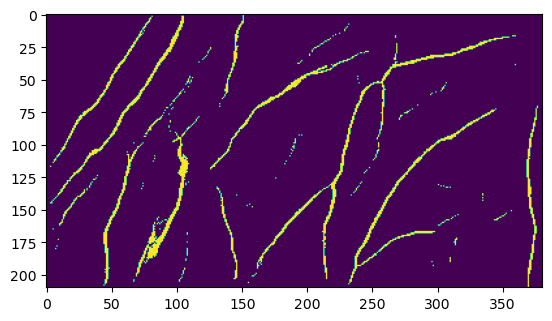

torch.Size([1543, 210, 381])
torch.Size([1543, 210, 381])
torch.Size([386, 128, 128])
torch.Size([386, 128, 128])
input max: tensor(1.)
input min: tensor(0.)
input type: torch.FloatTensor
target max: tensor(1.)
target min: tensor(0.)
target type: torch.FloatTensor
1543


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.model_selection import train_test_split
from load_data_every20_flip_crop import load_images, CustomTensorDataset
from load_HCA_data_every20_flip_crop import load_images as load_Hca_images
from load_data_simulated import load_synth_images
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms       
#init_transforms = transforms.Compose([transforms.CenterCrop(128)])
init_transforms = transforms.Compose([transforms.CenterCrop((128,128))])#,transforms.Normalize([0.5],[0.5])])
init_transforms_Hca = transforms.CenterCrop((210,381))

tensor_x, tensor_y = load_images()
tensor_x_hca, tensor_y_hca = load_Hca_images()
tensor_x_hca = init_transforms_Hca(tensor_x_hca)
tensor_y_hca = init_transforms_Hca(tensor_y_hca)

tensor_x = torch.cat((tensor_x,tensor_x_hca))
tensor_y = torch.cat((tensor_y,tensor_y_hca))
tensor_x = tensor_x/255
tensor_y = tensor_y/255

print(tensor_x.shape)
print(tensor_y.shape)

image_target = tensor_y[20,:,:].detach().numpy()
plt.imshow(image_target)
plt.show()
tensor_y = torch.where(tensor_y>0.5,1,0)
tensor_y = tensor_y.type(torch.FloatTensor)
image_target = tensor_y[20,:,:].detach().numpy()
plt.imshow(image_target)
plt.show()
tensor_x, tensor_x_val, tensor_y, tensor_y_val = train_test_split(tensor_x, tensor_y, test_size=0.2, random_state=1)
#tensor_x_sim = init_transforms(tensor_x_sim/255)
#tensor_y_sim = init_transforms(tensor_y_sim/255)
#print(tensor_x_sim.shape)


#tensor_x = init_transforms(tensor_x) #/255
#tensor_y = init_transforms_target(tensor_y) #/255
image_target = tensor_y[20,:,:].detach().numpy()
plt.imshow(image_target)
plt.show()

#tensor_x = torch.cat((tensor_x,tensor_x_sim))
#tensor_y = torch.cat((tensor_y,tensor_y_sim))
tensor_x_val = init_transforms(tensor_x_val) #/255
tensor_y_val = init_transforms(tensor_y_val) #/255
#tensor_x_test = init_transforms(tensor_x_test) /255
#tensor_y_test = init_transforms(tensor_y_test) /255
print(tensor_x.shape)
print(tensor_y.shape)
print(tensor_x_val.shape)
print(tensor_y_val.shape)
print("input max:",torch.max(tensor_x))
print("input min:",torch.min(tensor_x))
print("input type:",tensor_x.type())
print("target max:",torch.max(tensor_y))
print("target min:",torch.min(tensor_y))
print("target type:",tensor_y.type())



#my_dataset = TensorDataset(tensor_x,tensor_y) # create your datset

my_dataset = CustomTensorDataset(tensors=(tensor_x,tensor_y),transform=True,hflip_p=0.5,vflip_p=0.5)
#my_dataset_test = TensorDataset(tensor_x_test,tensor_y_test) # create your datset
my_dataset_val = TensorDataset(tensor_x_val,tensor_y_val)

my_dataloader = DataLoader(my_dataset,shuffle=True,batch_size=32)#, batch_size=1) # create your dataloader
#my_dataloader_test = DataLoader(my_dataset_test)
my_dataloader_val = DataLoader(my_dataset_val)
print(len(my_dataloader.dataset))


In [ ]:
a_transform = transforms.ToPILImage()
a_transform(tensor_x[0,:,:]).show()
tensor_x.shape[0]

In [2]:
class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()
      self.conv_stack =nn.Sequential(
        nn.Conv2d(1,32,3,stride=1,padding=1),
        nn.MaxPool2d((2,2),stride=2),
        nn.ReLU(),
        nn.Conv2d(32,128,3,stride=1,padding=1),
        nn.MaxPool2d((2,2),stride=2),
        nn.ReLU(),
        ##nn.Conv2d(256,512,3,stride=1,padding=1),
        ##nn.MaxPool2d((2,2),stride=2),
        #nn.ReLU(),
        #nn.ConvTranspose2d(512,256,4,stride=2,padding=1),
        #nn.Conv2d(256,256,3,stride=1,padding=1),
        #nn.ReLU(),
        nn.ConvTranspose2d(128,128,2,stride=2,padding=0),
        nn.Conv2d(128,32,3,stride=1,padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(32,32,2,stride=2,padding=0),
        #nn.ReLU(),
        #nn.Conv2d(64,128,3,stride=1,padding=1),
        nn.Conv2d(32,1,1,stride=1,padding=0),
        
        #nn.ReLU(),
        nn.Sigmoid()
        
        #nn.Softmax(dim=1)
        #nn.Softmax()
      )
    def forward(self, x):
      # Use the rectified-linear activation function over x
      output=self.conv_stack(x)
      # Apply softmax to x
      #output = F.log_softmax(x, dim=1)
      return output

my_nn = Net()
print(my_nn)

Net(
  (conv_stack): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): ConvTranspose2d(128, 128, kernel_size=(2, 2), stride=(2, 2))
    (7): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): ConvTranspose2d(32, 32, kernel_size=(2, 2), stride=(2, 2))
    (10): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
    (11): Sigmoid()
  )
)


In [4]:
costval = []
test_accuracy_list =[]
f1_scores = []
my_nn = Net()

criterion = nn.BCELoss()
#criterion = nn.BCEWithLogitsLoss()
#criterion = nn.CrossEntropyLoss()
#criterion = nn.MSELoss()
optimizer = torch.optim.Adam(my_nn.parameters())#,lr=0.3)
epochs=100

for j in range(epochs):
  print(j,"-------------------------------------------------")
  for i,(x_train,y_train) in enumerate(my_dataloader):
    x_train = torch.unsqueeze(x_train,1)
    y_pred = my_nn.forward(x_train)
    y_pred = torch.squeeze(y_pred)
    #print(y_pred.shape)
    #print(y_train.shape)
    #print(y_pred[0])
    #print(y_train[0])
    cost = criterion(y_pred,y_train)

    #backprop
    optimizer.zero_grad()
    #cost.mean().backward()
    cost.backward()
    optimizer.step()
  #costval.append(cost)
  #print(cost)

  accuracy=test_acc(my_nn,my_dataloader_test)
  #f1_s = f1(my_nn,my_dataloader_test)
  print("cost,MSE,F1:",cost,accuracy)#,f1_s)
  costval.append(cost)
  test_accuracy_list.append(accuracy)
  #f1_scores.append(f1_s)

0 -------------------------------------------------
cost,MSE,F1: tensor(0.4665, grad_fn=<BinaryCrossEntropyBackward0>) 0.9156585693359375
1 -------------------------------------------------
cost,MSE,F1: tensor(0.3073, grad_fn=<BinaryCrossEntropyBackward0>) 0.9156585693359375
2 -------------------------------------------------
cost,MSE,F1: tensor(0.2862, grad_fn=<BinaryCrossEntropyBackward0>) 0.9156585693359375
3 -------------------------------------------------
cost,MSE,F1: tensor(0.2288, grad_fn=<BinaryCrossEntropyBackward0>) 0.9156585693359375
4 -------------------------------------------------
cost,MSE,F1: tensor(0.2549, grad_fn=<BinaryCrossEntropyBackward0>) 0.9156585693359375
5 -------------------------------------------------
cost,MSE,F1: tensor(0.1309, grad_fn=<BinaryCrossEntropyBackward0>) 0.9156585693359375
6 -------------------------------------------------
cost,MSE,F1: tensor(0.1422, grad_fn=<BinaryCrossEntropyBackward0>) 0.93045654296875
7 ----------------------------------

KeyboardInterrupt: 

torch.Size([128, 128])
torch.Size([1, 128, 128])
1.0


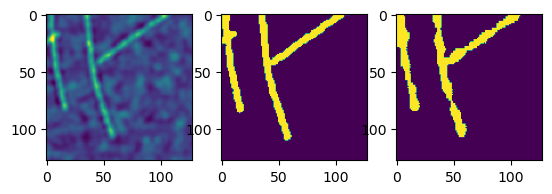

In [5]:
fig=0
x_test = tensor_x_test[fig]#.detach().numpy()
print(x_test.shape)
x_test = torch.unsqueeze(x_test,0)
print(x_test.shape)
y_pred = my_nn.forward(x_test)
y_pred=y_pred.detach().numpy()
y_pred=convToBinary(y_pred)
target = tensor_y_test[fig]
print(np.max(y_pred))
#target = target.detach().numpy()
#y_pred = np.reshape(y_pred,(128,128,2))
plt.subplot(1, 3, 1)
plt.imshow(x_test[0,:,:])

plt.subplot(1, 3, 2)
plt.imshow(target[:,:])
plt.subplot(1, 3, 3)
plt.imshow(y_pred[0,:,:])
#plt.imshow(target)

In [3]:
#ACCURACY FUNCTION
#Sörensen-Dice
from sklearn.metrics import f1_score
def f1(my_nn,my_dataloader_test):
        totalScore = 0
        for i,(x_test,y_test) in enumerate(my_dataloader_test):
                y_pred = my_nn.forward(x_test)
                y_pred = torch.squeeze(y_pred)
                y_pred = y_pred.flatten()
                target = y_test
                target = torch.squeeze(target)
                target = target.flatten()
                target = target.detach().numpy()
                y_pred = y_pred.detach().numpy()
                y_pred = convToBinary(y_pred)
                score = f1_score(target,y_pred,average="binary")
                #print(score)
                totalScore = totalScore + score
        N=len(my_dataloader_test)
        return totalScore/N
        #print("TotalScore: ",totalScore/N)
def test_acc(my_nn,my_dataloader_test):
    accuracy=0
    N = len(my_dataloader_test)
    for i,(x_test,y_test) in enumerate(my_dataloader_test):
        y_pred = my_nn.forward(x_test)
        target = y_test.detach().numpy()
        y_pred = y_pred.detach().numpy()
        y_pred = convToBinary(y_pred)
        accuracy = accuracy + acc(y_pred,target)
    return 1-accuracy/N
def convToBinary(output):
    binary_output=np.zeros_like(output)
    binary_output[output>0.5] = 1
    return binary_output
def acc(output,target):
    return ((output-target)**2).mean()

In [ ]:
#plot test accuracy and cost from last minibatch
def transform_list_of_tensor_to_numpy(tensorList):
    npArray=[]
    for i,tensor in enumerate(tensorList):
        npArray.append(tensor.detach())
    npArray = np.array(npArray)
    return npArray
costval_np = transform_list_of_tensor_to_numpy(costval)
plt.plot(costval_np,label="Training Cost")
plt.plot(test_accuracy_list,label="Test MSE")
plt.plot(f1_scores,label="Test F1")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Cost/Score")
plt.savefig("ex22_1_cost_score.pdf")
plt.show()

In [ ]:
def f1_full(my_nn,my_dataloader_test):

        f1_list=[]
        for i,(x_test,y_test) in enumerate(my_dataloader_test):
                y_pred = my_nn.forward(x_test)
                y_pred = torch.squeeze(y_pred)
                y_pred = y_pred.flatten()
                target = y_test
                target = torch.squeeze(target)
                target = target.flatten()
                target = target.detach().numpy()
                y_pred = y_pred.detach().numpy()
                y_pred = convToBinary(y_pred)
                score = f1_score(target,y_pred,average="binary")
                f1_list.append(score)
        return f1_list
f1_list = f1_full(my_nn,my_dataloader_test)
print(f1_list)
print(np.argmin(f1_list))

fig=np.argmin(f1_list)
x_test = tensor_x_test[fig]
y_pred = my_nn.forward(x_test)
y_pred=y_pred.detach().numpy()
print(y_pred)
y_pred=convToBinary(y_pred)
target = tensor_y_test[fig]
plotSave=True
plot=True
if plotSave==True:
        plt.imshow(y_pred[0,:,:])
        plt.savefig("ex22_1_worst_y_pred.pdf")
        plt.imshow(target[:,:])
        plt.savefig("ex22_1_worst_target.pdf")
        plt.imshow(x_test[1,:,:])
        plt.savefig("ex22_1_worst_x_test.pdf")
        ####BEST!
        fig=np.argmax(f1_list)
        x_test = tensor_x_test[fig]
        y_pred = my_nn.forward(x_test)
        y_pred=y_pred.detach().numpy()
        print(y_pred)
        y_pred=convToBinary(y_pred)
        target = tensor_y_test[fig]

        plt.imshow(y_pred[0,:,:])
        plt.savefig("ex22_1_best_y_pred.pdf")
        plt.imshow(target[:,:])
        plt.savefig("ex22_1_best_target.pdf")
        plt.imshow(x_test[1,:,:])
        plt.savefig("ex22_1_best_x_test.pdf")

if plot==True:
        plt.imshow(y_pred[0,:,:])

        plt.imshow(target[:,:])

        plt.imshow(x_test[1,:,:])

        ####BEST!
        fig=np.argmax(f1_list)
        x_test = tensor_x_test[fig]
        y_pred = my_nn.forward(x_test)
        y_pred=y_pred.detach().numpy()
        print(y_pred)
        y_pred=convToBinary(y_pred)
        target = tensor_y_test[fig]

        plt.imshow(y_pred[0,:,:])

        plt.imshow(target[:,:])

        plt.imshow(x_test[1,:,:])
